## UNECE CPR-generation-policy dataset

The aim of this notebook is to find a subset of the human annotations from the UNECE labelling sprint that has the highest agreement, and hence is most usable for tuning auto-evals.

The structure of the notebook:
- loading the data in from huggingface, and calculating the macro agreements without any exclusions
- running a grid-search on the user-combinations to be removed in order to find the best performing subset of the dataset -- this is done looking at the number of removed items and the agreement scores
- the final filtered dataset is then turned into scores, and saved -- this is pushed to s3 into the `project-rag/data/eval` bucket

In [1]:
import sys
import os
import argilla as rg
from itertools import chain
from pathlib import Path
from dotenv import load_dotenv, find_dotenv

sys.path.append(Path("../../").absolute().as_posix())

from src.dataset_creation.annotation_dashboard.iaa import calculate_iaa_table
from src.dataset_creation.annotation_dashboard.disagreement_chart import disagreement_plot
from src.dataset_creation.annotation_dashboard.utils import _filter_dataset_by_users
from src.evaluation.human import argilla_to_scores

load_dotenv(find_dotenv())


True

In [2]:
rg.init(api_url="https://argilla.labs.climatepolicyradar.org/", api_key=os.environ["ARGILLA_KEY"])

users = rg.User.list()

/Users/matyasjuhasz/git/rag-labs/.venv/lib/python3.11/site-packages/argilla/client/client.py:178: UserWarning: No workspace configuration was detected. To work with Argilla datasets, specify a valid workspace name on `rg.init` or set it up through the `rg.set_workspace` function.
  warnings.warn(
/Users/matyasjuhasz/git/rag-labs/.venv/lib/python3.11/site-packages/argilla/client/client.py:195: UserWarning: You're connecting to Argilla Server 1.26.1 using a different client version (1.29.0).
This may lead to potential compatibility issues during your experience.
To ensure a seamless and optimized connection, we highly recommend aligning your client version with the server version.
  warnings.warn(


In [3]:
feedback_from_hf = rg.FeedbackDataset.from_huggingface(
    "ClimatePolicyRadar/annotation-responses-unece"
)

Parsing records: 100%|██████████| 1700/1700 [00:31<00:00, 53.20it/s]


In [4]:
ids_in_ds = set(chain.from_iterable([[str(r.user_id) for r in rec.responses] for rec in feedback_from_hf.records if rec.responses]))
ids_to_user = {str(u.id): u.username for u in users if str(u.id) in ids_in_ds}
users_to_ids = {v: k for k, v in ids_to_user.items()}

In [5]:
df_nltk = calculate_iaa_table(
    feedback_from_hf,
    questions=[
        "cpr-generation-policy",
    ],
    engine="nltk",
    exclude_dont_know=True,
    rejected_users=None,
)

df_nltk

[07/11/24 16:42:51] INFO     Filtered dataset by removing 95 rows with missing values                   ]8;id=36899;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/utils.py\utils.py]8;;\:]8;id=472556;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/utils.py#57\57]8;;\

[07/11/24 16:42:51] INFO     INFO:src.dataset_creation.annotation_dashboard.utils:Filtered dataset by   ]8;id=265472;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/utils.py\utils.py]8;;\:]8;id=806920;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/utils.py#57\57]8;;\
                             removing 95 rows with missing values                                                  

[07/11/24 16:42:51] INFO     Excluding responses: ['DONT_KNOW', 'NOT_APPLICABLE']                         ]8;id=146260;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/iaa.py\iaa.py]8;;\:]8;id=773659;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/iaa.py#99\99]8;;\

                    INFO     INFO:src.dataset_creation.annotation_dashboard.iaa:Excluding responses:      ]8;id=367731;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/iaa.py\iaa.py]8;;\:]8;id=16763;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/iaa.py#99\99]8;;\
                             ['DONT_KNOW', 'NOT_APPLICABLE']                                                       

,count,krippendorff_alpha,average_pairwise_agreement,average_pairwise_cohen_kappa,question,skew,imbalance_ratio,entropy
0,2277,0.289623,0.829539,0.471451,cpr-generation-policy,-1.724657,4.764557,0.461352


[07/11/24 16:42:52] INFO     Filtered dataset by removing 7 rows with missing values                    ]8;id=386407;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/utils.py\utils.py]8;;\:]8;id=322487;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/utils.py#57\57]8;;\

[07/11/24 16:42:52] INFO     INFO:src.dataset_creation.annotation_dashboard.utils:Filtered dataset by   ]8;id=105690;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/utils.py\utils.py]8;;\:]8;id=795799;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/utils.py#57\57]8;;\
                             removing 7 rows with missing values                                                   

[07/11/24 16:42:52] INFO     Plotting disagreement chart for question:                     ]8;id=746235;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/disagreement_chart.py\disagreement_chart.py]8;;\:]8;id=91708;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/disagreement_chart.py#62\62]8;;\
                             cpr-generation-policy with 2277 responses                                             

                    INFO     INFO:src.dataset_creation.annotation_dashboard.disagreement_c ]8;id=542931;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/disagreement_chart.py\disagreement_chart.py]8;;\:]8;id=474077;file:///Users/matyasjuhasz/git/rag-labs/notebooks/dataset-generation/../../src/dataset_creation/annotation_dashboard/disagreement_chart.py#62\62]8;;\
                             hart:Plotting disagreement chart for question:                                        
                             cpr-generation-policy with 2277 responses                                             

(<Figure size 2500x8500 with 85 Axes>, <Figure size 640x480 with 1 Axes>)

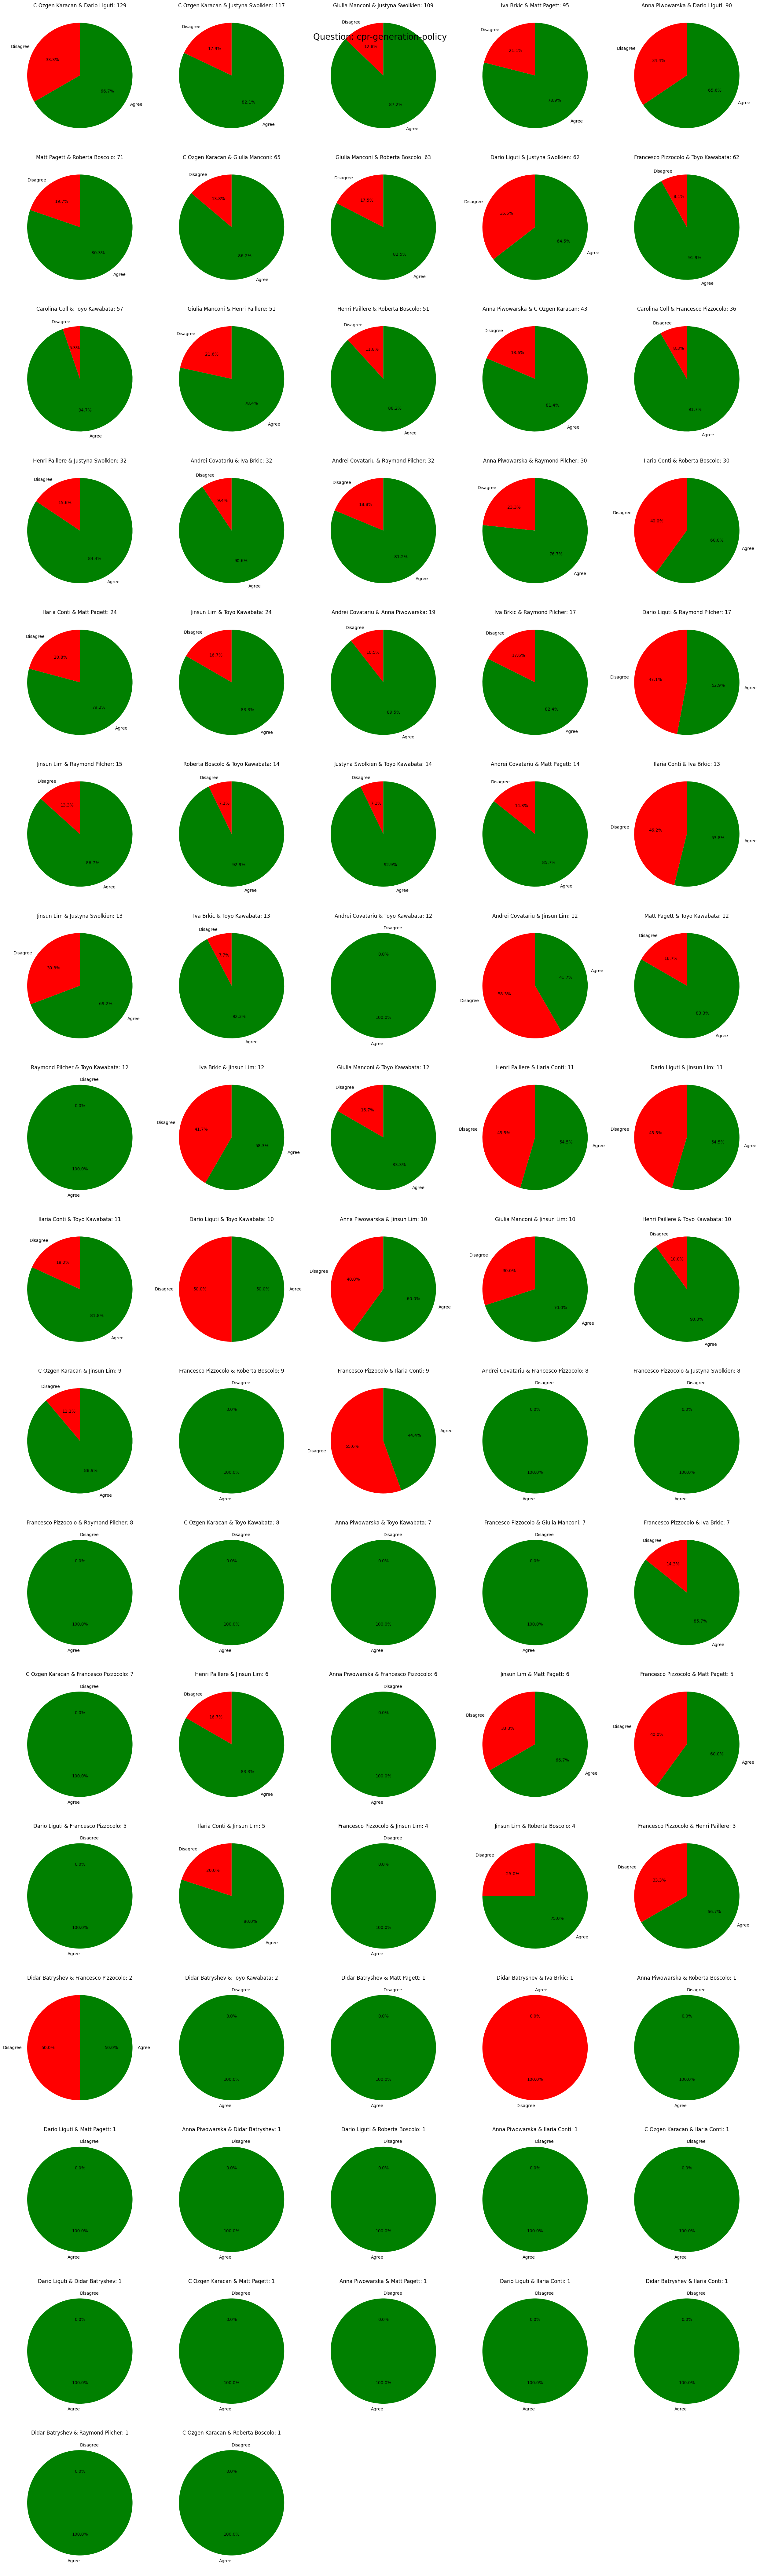

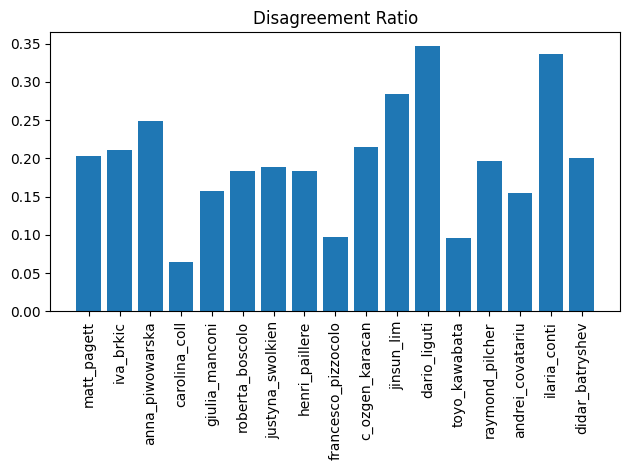

In [6]:
disagreement_plot(feedback_from_hf, "cpr-generation-policy", ids_to_user, exclude_dont_know=True)

In [7]:
# we are trying to minimize the amount of annotations thrown away and maximize kappa and APA

In [8]:
from itertools import combinations, chain
from tqdm import tqdm
import logging

logging.disable(sys.maxsize)

all_user_combinations = [(id,) for id in users_to_ids.values()] + list(
    chain.from_iterable(
        combinations(users_to_ids.values(), r) for r in range(2, 4)
    )
)

len(all_user_combinations)

987

In [9]:
kappas = []
counts = []
apas = []

for users_to_exclude in tqdm(all_user_combinations):
    df_nltk = calculate_iaa_table(
        feedback_from_hf,
        questions=[
            "cpr-generation-policy",
        ],
        engine="nltk",
        exclude_dont_know=True,
        rejected_users=users_to_exclude,
    )

    counts.append(df_nltk["count"][0])
    kappas.append(df_nltk["average_pairwise_cohen_kappa"][0])
    apas.append(df_nltk["average_pairwise_agreement"][0])

100%|██████████| 987/987 [08:16<00:00,  1.99it/s]


986it [00:00, 3794.63it/s]


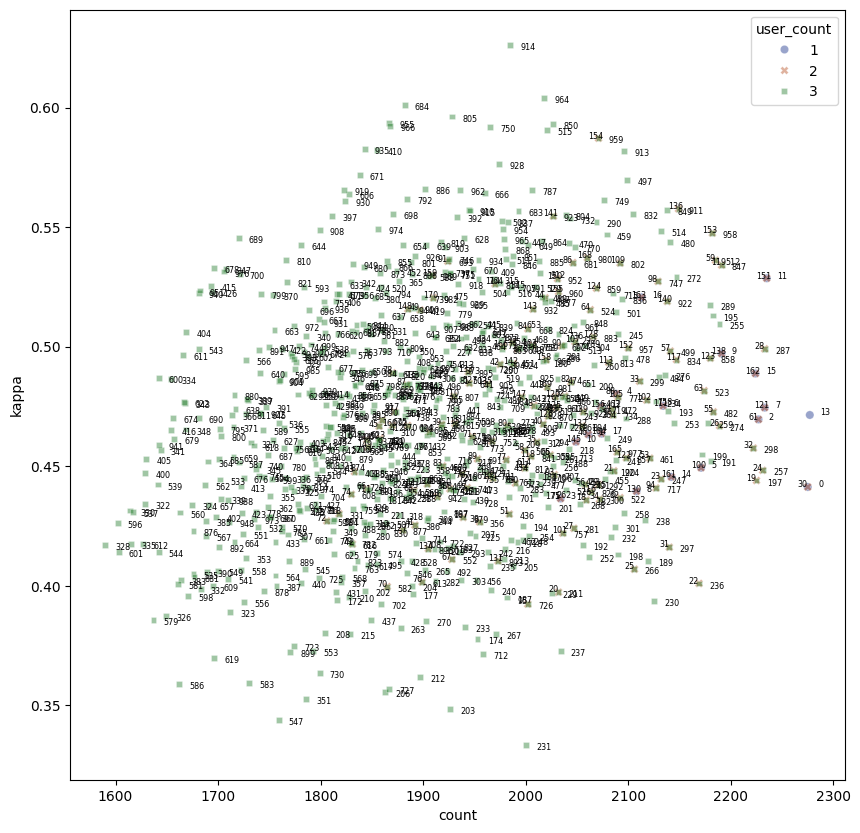

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


df = pd.DataFrame({"kappa": kappas, "count": counts, "user": all_user_combinations, "user_count": [len(u) for u in all_user_combinations]})

limit=-1


fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df.head(limit), x="count", y="kappa", style="user_count", hue="user_count", alpha=0.4, palette="dark", ax=ax)


for label, (k, c, uc) in tqdm(enumerate(zip(df["kappa"].head(limit), df["count"].head(limit), df["user_count"].head(limit))), total=limit):
    if uc == 1:
        pos = (c + 10, k)
    elif uc == 2:
        pos = (c - 10, k)
    elif uc == 3:
        pos = (c + 10, k - 0.002)
    ax.text(*pos, str(label), fontdict={"fontsize": "xx-small"})

plt.show()

In [11]:
[ids_to_user[i] for i in all_user_combinations[914]]

['henri_paillere', 'jinsun_lim', 'iva_brkic']

In [12]:
[ids_to_user[i] for i in all_user_combinations[231]]

['didar_batryshev', 'francesco_pizzocolo', 'toyo_kawabata']

In [9]:
rejected_users = [users_to_ids[u] for u in ['henri_paillere', 'jinsun_lim', 'iva_brkic']]

In [10]:
df_nltk = calculate_iaa_table(
    feedback_from_hf,
    questions=[
        "cpr-generation-policy",
    ],
    engine="nltk",
    exclude_dont_know=True,
    rejected_users=rejected_users,
)

df_nltk

,count,krippendorff_alpha,average_pairwise_agreement,average_pairwise_cohen_kappa,question,skew,imbalance_ratio,entropy
0,1985,0.303735,0.879729,0.626269,cpr-generation-policy,-1.698675,4.671429,0.465771


In [11]:
filtered_feedback_ds = _filter_dataset_by_users(feedback_from_hf, rejected_users)

(<Figure size 2500x5500 with 55 Axes>, <Figure size 640x480 with 1 Axes>)

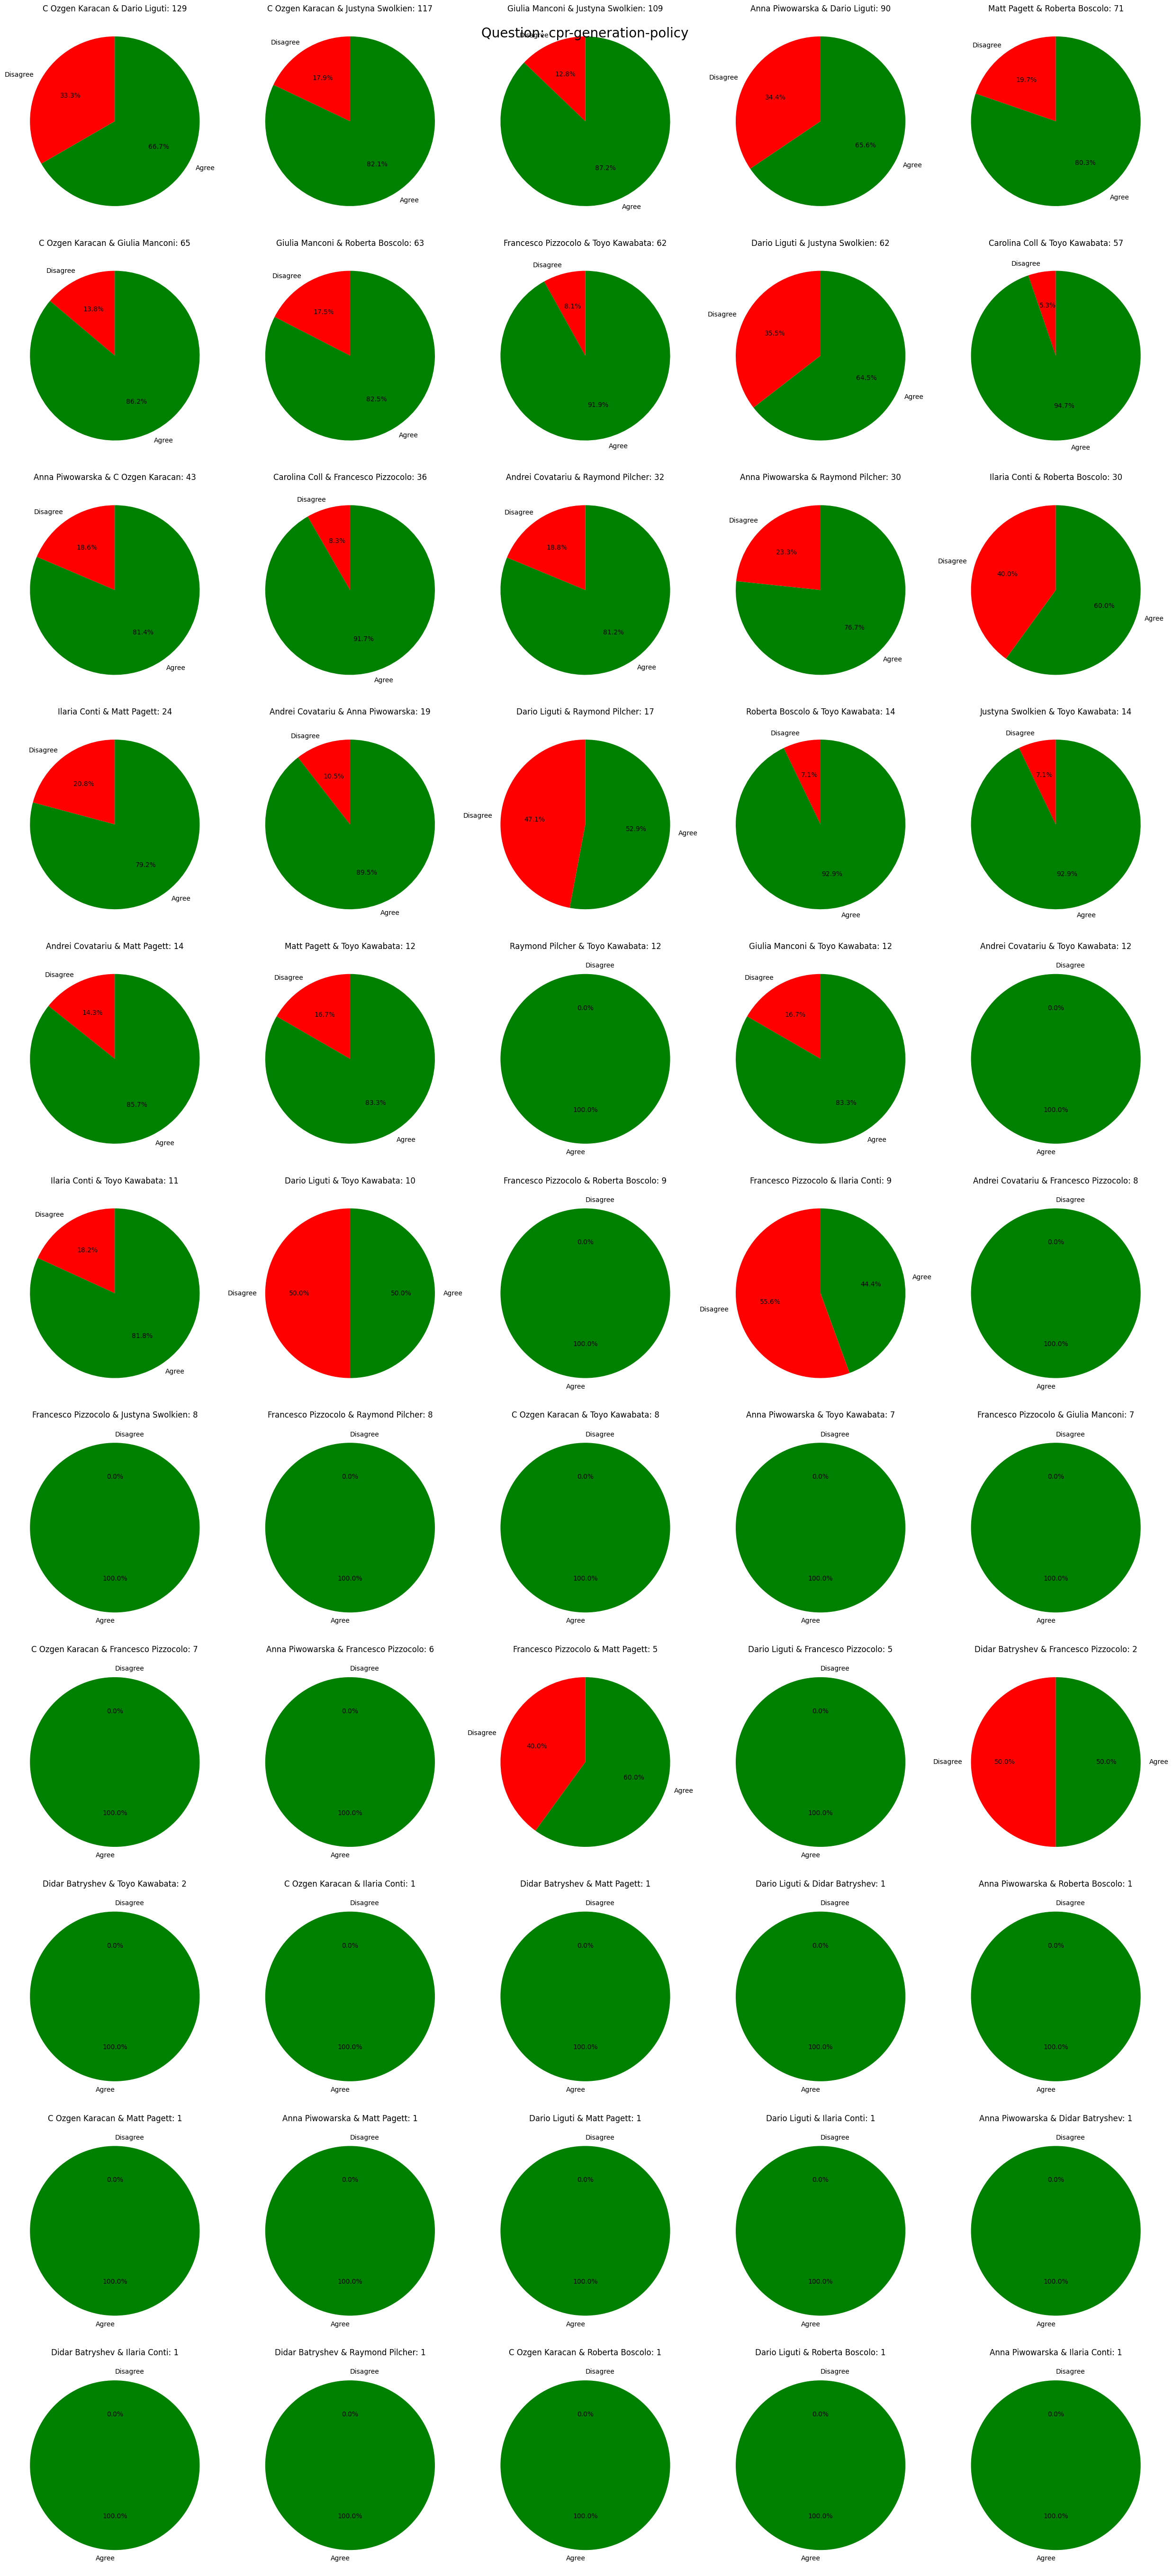

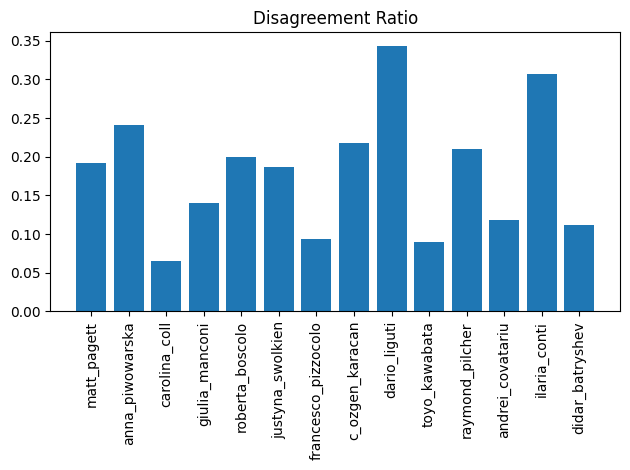

In [12]:
disagreement_plot(filtered_feedback_ds, "cpr-generation-policy", ids_to_user, exclude_dont_know=True)

In [13]:
scores = argilla_to_scores(filtered_feedback_ds, "average", ["cpr-generation-policy"])

In [14]:
with open("../../data/eval/cpr_generation_policy_human_annotation_scores_average.jsonl", "w") as f:
    for score in scores:
        f.write(f"{score.model_dump_json()}\n")